In [119]:
import os
from os import listdir
import re
import sys
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
from tqdm import tqdm
import pandas as pd
from time import time
import datetime
import segmentation_models as sm
import albumentations as A
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import TensorBoard, EarlyStopping, ReduceLROnPlateau
from keras.layers import concatenate, Dense, Dropout, Input, add, Conv2D, BatchNormalization, MaxPooling2D, Conv2DTranspose, Activation, Concatenate
from keras import backend as keras
from keras.optimizers import Adam
from keras.models import Model
import PIL

print("Version: ", tf.__version__)
if tf.test.gpu_device_name():
        print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

Version:  2.9.0
Default GPU Device: /device:GPU:0


(256, 256, 3)


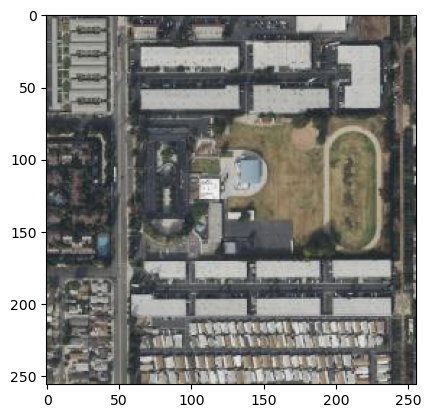

In [120]:
img = plt.imread('processed-images/resized-all/1.jpg')
print(img.shape)
plt.imshow(img)
#plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))

(256, 256, 3)


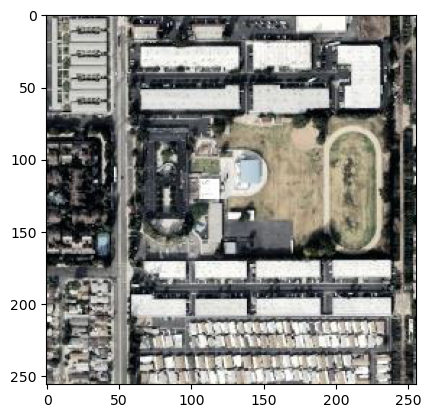

In [121]:
img = plt.imread('processed-images/equalized-all/1.jpg')
print(img.shape)
plt.imshow(img)
#plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))

(256, 256)


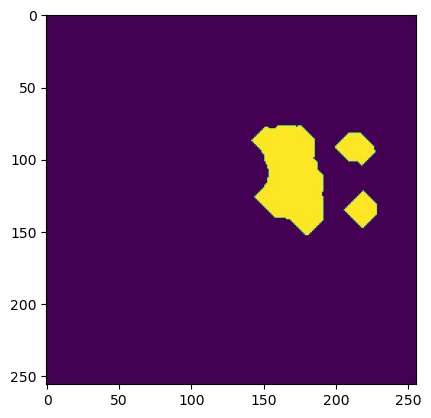

In [122]:
img = plt.imread('processed-images/mask-equalized-all//1.jpg')
print(img.shape)
plt.imshow(img)

(256, 256)


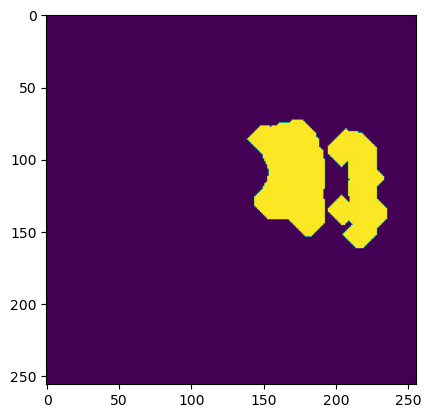

In [123]:
img = plt.imread('processed-images/mask-resized-all//1.jpg')
print(img.shape)
plt.imshow(img)

In [124]:
# this function lists files from directory
def build_data(TRAIN_PATH, LABEL_PATH):
    train = []
    label = []
    filenames = sorted(listdir(TRAIN_PATH))
    for name in filenames:
        train.append(TRAIN_PATH + '/' + name)
        
    filenames = sorted(listdir(LABEL_PATH))
    for name in filenames:
        label.append(LABEL_PATH + '/' + name)
        
    return train, label

# first with equalized images
eq_sat_image, eq_mask_image = build_data('processed-images/equalized-all', 'processed-images/mask-equalized-all')   

# resized images
sat_image, mask_image = build_data('processed-images/resized-all', 'processed-images/mask-resized-all')   

##### =^.^=  =^.^=  =^.^=  =^.^=  =^.^=  =^.^=  =^.^=  =^.^=  =^.^=  =^.^=  =^.^=  =^.^=  =^.^=  =^.^=  =^.^=  =^.^=  =^.^=  =^.^=  =^.^=  =^.^=  =^.^=  =^.^=  =^.^=  =^.^=  =^.^=  

In [125]:
# this function builds the dataframes for the image's path
def build_dataframe(SAT_IMAGE, MASK_IMAGE):
    df = pd.DataFrame({
        'Image' : SAT_IMAGE,
        'Mask' : MASK_IMAGE
    })

    return df

In [126]:
from sklearn.utils import shuffle

In [127]:
# building the dataframes

# for resized images
df_res = build_dataframe(sat_image, mask_image)
df_res = shuffle(df_res)

# for equalized images
df_eq = build_dataframe(eq_sat_image, eq_mask_image)
df_eq = shuffle(df_eq)


In [128]:
# https://albumentations.ai/docs/getting_started/image_augmentation/
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-15, 15),
        shear=(-15, 15)
    )
    #A.Blur(blur_limit = 5, p = 0.85), 
])

In [129]:
# get sizes for train, validation and test data
def get_sizes(df):
    train_size = int(0.8 * df.shape[0])
    val_size = int(0.2 * df.shape[0])
    test_size = int(0.1 * df.shape[0])

    return train_size, val_size, test_size

In [130]:
print(get_sizes(df_res), get_sizes(df_eq))

(2177, 544, 272) (2177, 544, 272)


In [131]:
def split_data(df):
    train_size, validation_size, test_size = get_sizes(df)

    X_train, y_mask_train = (df[:train_size], df[:train_size])
    X_validation, y_mask_validation = (df[train_size:train_size+test_size], df[train_size:train_size+test_size])
    X_test, y_mask_test = (df[train_size+test_size:], df[train_size+test_size:])

    return X_train, X_validation, X_test    

In [132]:
# spliting for resized images
X_train, X_validation, X_test = split_data(df_res)
print(len(X_train), len(X_validation), len(X_test))

2177 272 273


In [133]:
# spliting for equalized images
X_train_eq, X_validation_eq, X_test_eq = split_data(df_eq)
print(len(X_train_eq), len(X_validation_eq), len(X_test_eq))

2177 272 273


In [134]:
# https://albumentations.ai/docs/getting_started/mask_augmentation/

IMG_SIZE = (256, 256)

def modify_mask(mask):
    # (256, 256) -> (256, 256, 1)
    mask = np.expand_dims(mask, axis = 2)
    t_mask = np.zeros(mask.shape)
    
    # onde na máscara original for maior que 100, a t_mask vira 1
    np.place(t_mask[:, :, 0], mask[:, :, 0] >=100, 1)
    return t_mask

# associa máscara à imagem
def map_function(img, mask):
    img, mask = plt.imread(img.decode()), plt.imread(mask.decode())
    img = cv.resize(img, IMG_SIZE)
    mask = modify_mask(cv.resize(mask, IMG_SIZE))
    img = img/255.0
    transformed = transform(image=img, mask=mask)
    img = transformed['image']
    mask = transformed['mask']

    return img.astype(np.float64), mask.astype(np.float64)

In [135]:
# https://www.tensorflow.org/api_docs/python/tf/data/Dataset

# A tf.int64 scalar tf.Tensor, representing the number of consecutive elements of this dataset to combine in a single batch.
BATCH_SIZE = 6

# passa como entrada o dataframe
def create_dataset(data):
    dataset = tf.data.Dataset.from_tensor_slices((data['Image'], data['Mask']))
    
    #(<tf.Tensor: shape=(), dtype=string, numpy=b'train/125.jpg'>, <tf.Tensor: shape=(), dtype=string, numpy=b'train_labels/125.jpg'>)
    
    dataset = dataset.shuffle(1000)

    # aplica uma função a cada elemento do dataset e retorna um novo dataset contendo
    # os elementos transformados
    # nesse caso, chama a função que aplica a função tranformed
    dataset = dataset.map(lambda img, mask : tf.numpy_function(
                    map_function, [img, mask], [tf.float64, tf.float64]),
                    num_parallel_calls = tf.data.experimental.AUTOTUNE).batch(BATCH_SIZE)

    # This allows later elements to be prepared while the current element is being processed. This often improves latency and throughput, at the cost of using additional memory to store prefetched elements.
    dataset = dataset.prefetch(buffer_size = tf.data.experimental.AUTOTUNE)
    return dataset

In [136]:
def iter_dataset(X_dataset):
    dataset = create_dataset(X_dataset)
    img, mask = next(iter(dataset))
    print(img.shape, mask.shape)
    return dataset

In [137]:
# create train dataset for resised images
train_dataset = iter_dataset(X_train)

# create validation dataset for resized images
validation_dataset = iter_dataset(X_validation)

# create train dataset for equalized images
train_dataset_eq = iter_dataset(X_train_eq)

# create validation dataset for equalized images
validation_dataset_eq = iter_dataset(X_validation_eq)

(6, 256, 256, 3) (6, 256, 256, 1)
(6, 256, 256, 3) (6, 256, 256, 1)
(6, 256, 256, 3) (6, 256, 256, 1)
(6, 256, 256, 3) (6, 256, 256, 1)


### **Métricas para avaliar o modelo de segmentação**

* Desde que em um modelo de segmentação não é possivel definir a porcentagem de acurácia, as métricas usadas para avaliar a qualidade da segmentação são:

- 1. DICE COEF
    - Usado para comparar os pixels da segmentação prevista a segmentação correspondente à imagem original.
    - A fórmula é: 2 vezes a area de sobreposição dos das duas imagens (original e prevista) dividido pelo número total de bits nas duas imagens.
    - Varia entre 0 e 1 (0%-100%), sendo 1 maior similaridade entre a imagem prevista e a verdadeira.


- 2. Intersection-Over-Union (IoU, Jaccard Index)
    - É dada pela área de sobreposição entra a segmentação prevista e a segmentação real dividido pela área de união entre a segmentação prevista e a real.
    - Varia entre 0 e 1 (0%-100%), sendo 1 maior similaridade entre a imagem prevista e a verdadeira.
    - Para multiplas classes a média IoU é calculada tirando a média do IoU de cada classe.

In [138]:
# function to evaluate the dice coef in the unet training
def dice_coef(y_true, y_pred):
    y_true_f = keras.flatten(y_true)
    y_pred_f = keras.flatten(y_pred)
    intersection = keras.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1.0) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + 1.0) 

# function to evaluate the dice coef loss in the unet training
def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [139]:
# function to evaluate the dice coef in the test dataframe
def dice_coef_test(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    union = np.sum(y_true_f) + np.sum(y_pred_f)
    if union==0: return 1
    intersection = np.sum(y_true_f * y_pred_f)
    return 2. * intersection / union

In [140]:
def unet1(input_size=(256,256,1)):
    inputs = Input(input_size)

    #Block 1
    # codificador (parte esquerda do “U”)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    pool1 = Dropout(0.2)(pool1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    pool2 = Dropout(0.2)(pool2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    pool3 = Dropout(0.2)(pool3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    pool4 = Dropout(0.2)(pool4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = Dropout(0.2)(conv5)

    # decodificador (parte direita do “U”)
    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = Dropout(0.2)(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = Dropout(0.2)(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)
    conv8 = Dropout(0.2)(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)
    conv9 = Dropout(0.2)(conv9)
    
    # bottleneck
    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

In [141]:
def unet2(input_size=(256,256,1)):
    inputs = Input(input_size)

    #Block 1
    # codificador (parte esquerda do “U”)
    conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    #conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    pool1 = Dropout(0.2)(pool1)

    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    pool2 = Dropout(0.2)(pool2)

    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    pool3 = Dropout(0.2)(pool3)

    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    pool4 = Dropout(0.2)(pool4)

    conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = Dropout(0.2)(conv5)

    # decodificador (parte direita do “U”)
    up6 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = Dropout(0.2)(conv6)

    up7 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = Dropout(0.2)(conv7)

    up8 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(32, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv8)
    conv8 = Dropout(0.2)(conv8)

    up9 = concatenate([Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(16, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv9)
    conv9 = Dropout(0.2)(conv9)
    
    # bottleneck
    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

In [157]:
def unet3(input_size=(256,256,1)):
    inputs = Input(input_size)
    #Block 1
    # codificador (parte esquerda do “U”)
    conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    #pool1 = Dropout(0.1)(pool1)

    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    #pool2 = Dropout(0.1)(pool2)

    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    #pool3 = Dropout(0.1)(pool3)

    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    #pool4 = Dropout(0.1)(pool4)

    conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv5)
    #conv5 = Dropout(0.1)(conv5)
    # decodificador (parte direita do “U”)
    up6 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    up6 = BatchNormalization()(up6)
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(up6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    #conv6 = Dropout(0.1)(conv6)

    up7 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    up7 = BatchNormalization()(up7)
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(up7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    #conv7 = Dropout(0.1)(conv7)

    up8 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    up8 = BatchNormalization()(up8)
    conv8 = Conv2D(32, (3, 3), activation='relu', padding='same')(up8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)
    #conv8 = Dropout(0.1)(conv8)

    up9 = concatenate([Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    up9 = BatchNormalization()(up9)
    conv9 = Conv2D(16, (3, 3), activation='relu', padding='same')(up9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv9)
    conv9 = BatchNormalization()(conv9)
    #conv9 = Dropout(0.1)(conv9)
    
    # bottleneck
    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

In [158]:
# callbacks = [EarlyStopping(patience=6, monitor='loss'), 
#              ReduceLROnPlateau(factor=np.sqrt(0.1), patience=2, min_lr=0.5e-6)]
callbacks = [EarlyStopping(patience=6, monitor='loss')]

In [144]:
def return_model_unet1():
    model = unet1(input_size = (256, 256, 3))
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss=["binary_crossentropy", dice_coef_loss],
        metrics=[dice_coef, 'binary_accuracy', sm.metrics.iou_score]
    )
    #model.summary()
    
    return model

In [159]:
def return_model_unet2():
    model = unet2(input_size = (256, 256, 3))
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss=["binary_crossentropy", dice_coef_loss],
        metrics=[dice_coef, 'binary_accuracy', sm.metrics.iou_score]
    )
    #model.summary()
    
    return model

In [160]:
def return_model_unet3():
    model = unet3(input_size = (256, 256, 3))
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss=["binary_crossentropy", dice_coef_loss],
        metrics=[dice_coef, 'binary_accuracy', sm.metrics.iou_score]
    )
    #model.summary()
    
    return model

In [161]:
# model resize
model_res_unet1 = return_model_unet1()
model_res_unet2 = return_model_unet2()
model_res_unet3 = return_model_unet3()


# model equalized
model_eq_unet1 = return_model_unet1()
model_eq_unet2 = return_model_unet2()
model_eq_unet3 = return_model_unet3()


In [162]:
# training for equalized images
history_eq_unet3_3 = model_eq_unet3.fit(
    train_dataset_eq,
    validation_data = validation_dataset_eq, 
    batch_size = 6,
    epochs = 100,
    callbacks = [callbacks]
)

Epoch 1/100
363/363 [==============================] - 408s 1s/step - loss: 0.5901 - dice_coef: 0.2124 - binary_accuracy: 0.7920 - iou_score: 0.1251 - val_loss: 0.4482 - val_dice_coef: 0.1960 - val_binary_accuracy: 0.9103 - val_iou_score: 0.1154
Epoch 2/100
363/363 [==============================] - 397s 1s/step - loss: 0.3860 - dice_coef: 0.2815 - binary_accuracy: 0.9443 - iou_score: 0.1754 - val_loss: 0.2700 - val_dice_coef: 0.3395 - val_binary_accuracy: 0.9645 - val_iou_score: 0.2217
Epoch 3/100
363/363 [==============================] - 397s 1s/step - loss: 0.3047 - dice_coef: 0.3224 - binary_accuracy: 0.9563 - iou_score: 0.2094 - val_loss: 0.2350 - val_dice_coef: 0.3756 - val_binary_accuracy: 0.9724 - val_iou_score: 0.2513
Epoch 4/100
363/363 [==============================] - 399s 1s/step - loss: 0.2498 - dice_coef: 0.3693 - binary_accuracy: 0.9645 - iou_score: 0.2518 - val_loss: 0.1880 - val_dice_coef: 0.3910 - val_binary_accuracy: 0.9652 - val_iou_score: 0.2601
Epoch 5/100
363/

In [163]:
model_eq_unet3.save('projeto-hu-unet3-equalized-b6-e100-2.h5')

In [ ]:
# training for equalized images
history_eq_unet3 = model_eq_unet3.fit(
    train_dataset_eq,
    validation_data = validation_dataset_eq, 
    batch_size = 3,
    epochs = 100,
    callbacks = [callbacks]
)

In [ ]:
# training for equalized images
history_eq_unet2 = model_eq_unet2.fit(
    train_dataset_eq,
    validation_data = validation_dataset_eq, 
    batch_size = 6,
    epochs = 100,
    callbacks = [callbacks]
)

In [29]:
model_eq_unet2.save('projeto-hu-unet2-equalized-b6-e30-2.h5')

In [ ]:
# training for resized images
history_res_unet2 = model_res_unet2.fit(
    train_dataset,
    validation_data = validation_dataset, 
    batch_size = 6,
    epochs = 100,
    callbacks = [callbacks]
)

In [126]:
model_res_unet2.save('projeto-hu-unet2-resized-b6-e30-2.h5')

In [ ]:
# training for equalized images
history_eq_unet1 = model_eq_unet1.fit(
    train_dataset_eq,
    validation_data = validation_dataset_eq, 
    batch_size = 6,
    epochs = 30,
    callbacks = [callbacks]
)

In [128]:
model_eq_unet1.save('projeto-hu-unet1-equalized-b6-e30.h5')

In [ ]:
# training for resized images
history_res_unet1 = model_res_unet1.fit(
    train_dataset,
    validation_data = validation_dataset,
    batch_size = 6,
    epochs = 30,
    callbacks = [callbacks]
)

In [130]:
model_res_unet1.save('projeto-hu-unet1-resized-b6-e30.h5')

In [ ]:
# training for equalized images
history_eq_unet1 = model_eq_unet1.fit(
    train_dataset_eq,
    validation_data = validation_dataset_eq, 
    batch_size = 6,
    epochs = 30,
    callbacks = [callbacks]
)

In [72]:
def test_on_image(model, df, img_num, img_side_size = 256):
    
    img = plt.imread(df['Image'][img_num])
    img_og = img
    
    img = (img/255.0)
    img = np.expand_dims(cv.resize(img, (256, 256)), 0)
    img = img.astype(np.float32)
    
    # -----
    
    mask = plt.imread(df['Mask'][img_num])
    mask = (mask/255.0)
    
    """ para dados de previsão >= .5 atribuiremos 1, caso contrário, o valor será 0 """
    #pred = model.predict(img_array[img_num].reshape(1,img_side_size,img_side_size,1))
    pred = model.predict(img)
    pred[pred>0.5] = 1.0
    pred[pred<0.5] = 0.0
    fig = plt.figure(figsize = (15,10))
    
    print(dice_coef_test(y_true=mask, y_pred=pred))
    
    plt.subplot(1,4,1)
    plt.imshow(pred.reshape(img_side_size, img_side_size), cmap = "viridis")
    plt.title("Previsão")
    plt.axis("off")
    
    plt.subplot(1,4,2)
    plt.imshow(mask, cmap = "viridis")
    plt.title("Máscara real");
    plt.axis("off")
    
    plt.subplot(1,4,3)
    plt.imshow(mask, cmap = "viridis", alpha = 0.5)
    plt.imshow(pred.reshape(img_side_size, img_side_size),cmap = "PuBu", alpha = 0.3)
    plt.title("Sobreposição")
    plt.axis("off")
    
    plt.subplot(1,4,4)
    plt.imshow(img_og)
    plt.title("Original")
    plt.axis("off")
    
    return pred

1/1 [==============================] - 5s 5s/step
0.7287707928278246


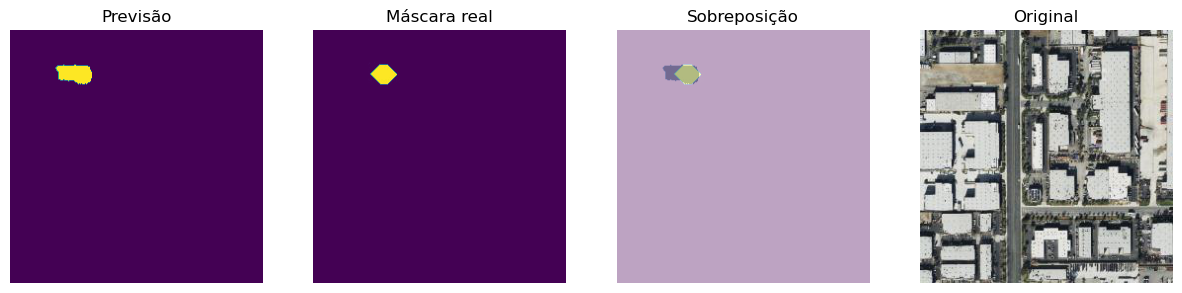

In [73]:
IMG_NUM = 10 #selecionando uma imagem pela posição
prediction = test_on_image(model_eq_unet3, df_res, img_num = IMG_NUM, img_side_size = 256)

In [31]:
def get_metrics(history):
    fig = plt.figure(figsize = (15,15))
    plt.subplot(2,2,1)
    plt.plot(history.history["loss"], label = "training loss")
    plt.plot(history.history["val_loss"], label = "validation loss")
    plt.title("Validação x Treino: Entropia Cruzada", fontsize=18, y=1)
    plt.legend()
    plt.xlabel("Época")
    plt.ylabel("Entropia cruzada binária")

    plt.subplot(2,2,2)
    plt.plot(history.history["dice_coef"], label = "training dice coefficient")
    plt.plot(history.history["val_dice_coef"], label = "validation dice coefficient")
    plt.title("Validação x Treino: Coeficiente Dice", fontsize=18, y=1)
    plt.legend()
    plt.xlabel("Época")
    plt.ylabel("Coeficiente Dice")

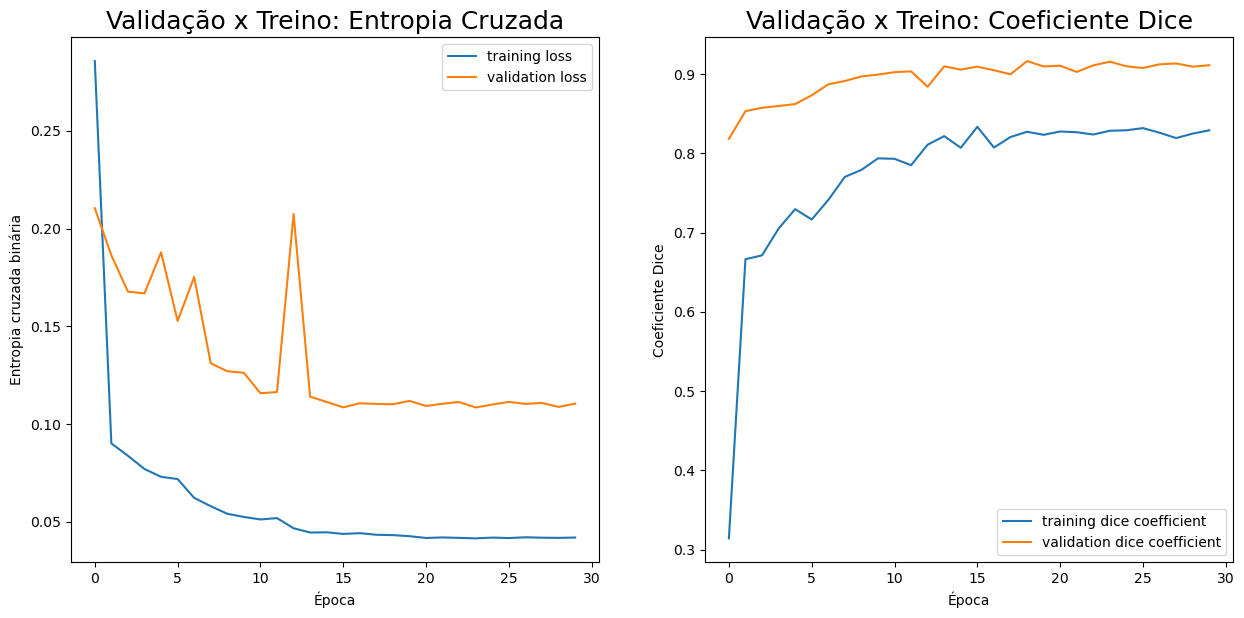

In [144]:
get_metrics(history = history_res_unet1)

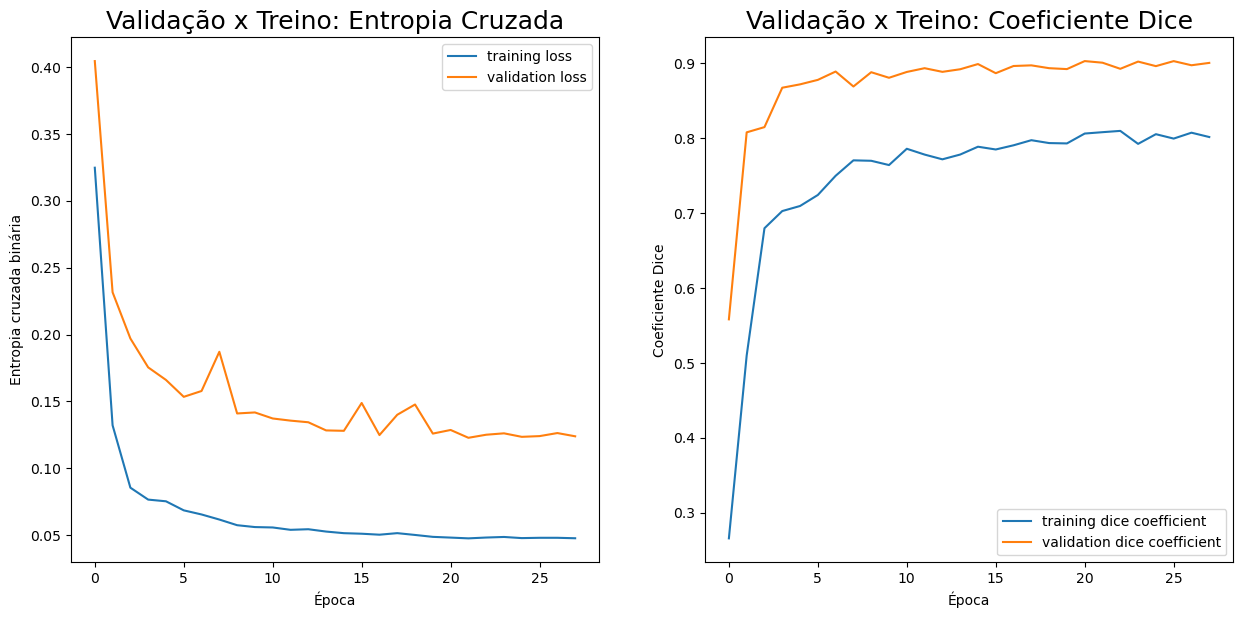

In [136]:
get_metrics(history = history_res_unet2)

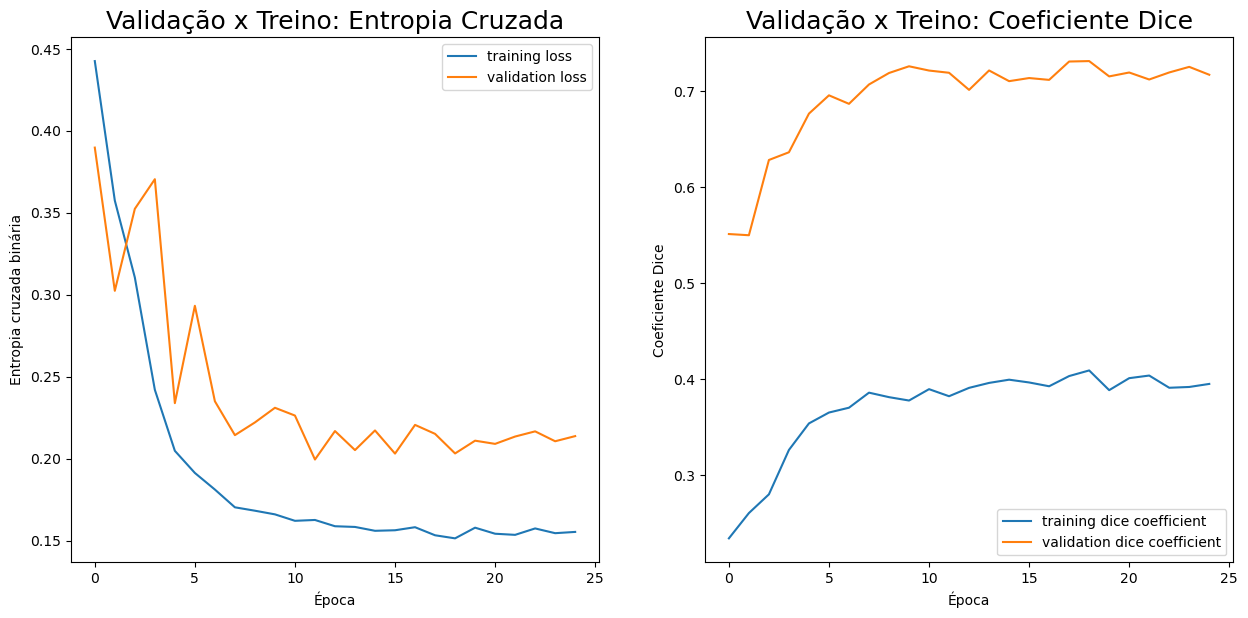

In [84]:
get_metrics(history = history_eq_unet3_2)


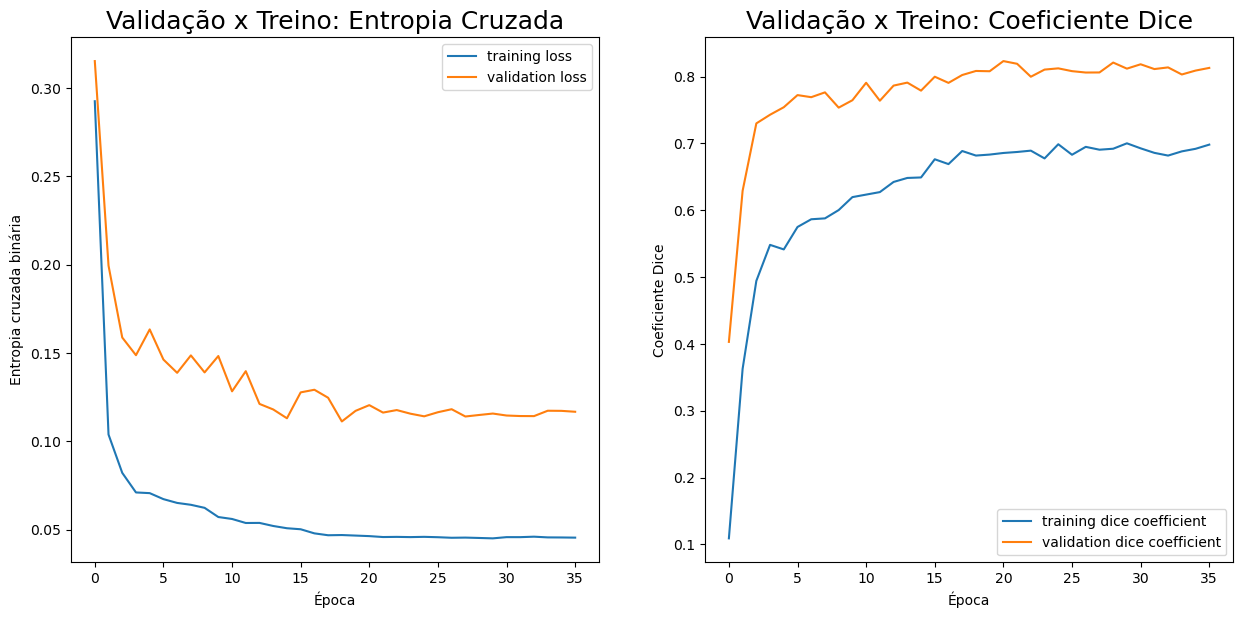

In [32]:
get_metrics(history = history_eq_unet2)

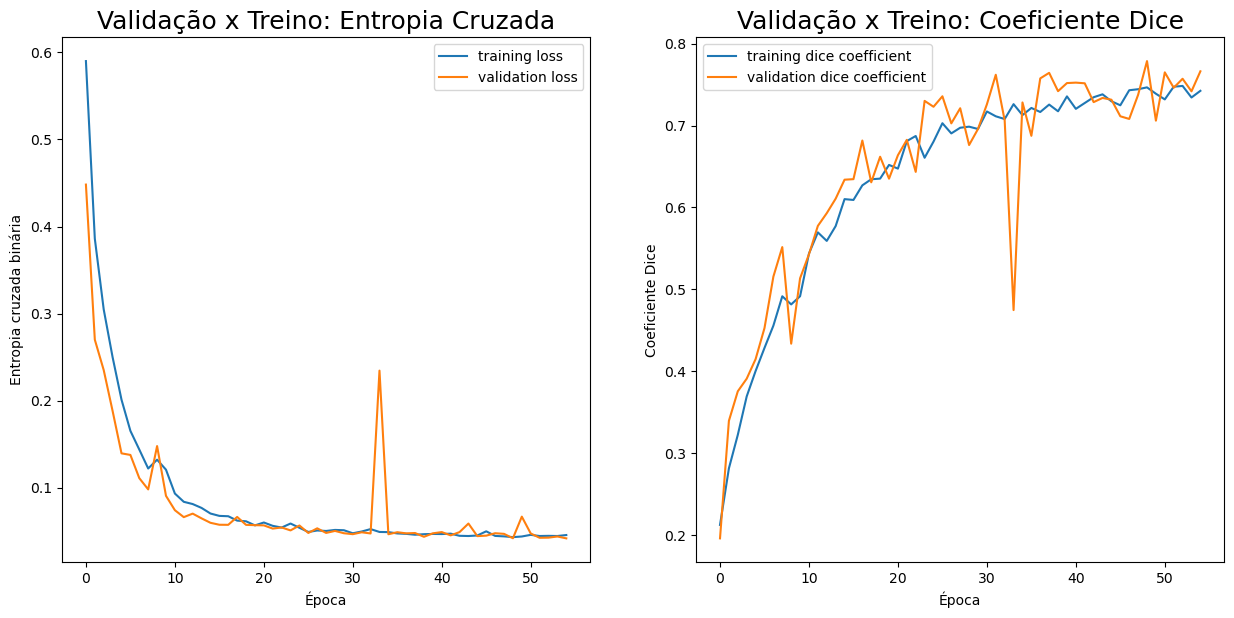

In [164]:
#history_eq_unet3_3
get_metrics(history = history_eq_unet3_3)

In [78]:
objects = {
    'dice_coef' : dice_coef,
    'dice_coef_loss' : dice_coef_loss,
    'iou_score' : sm.metrics.iou_score
}

In [77]:
# magenta
color = [255, 0, 255]
# normalizando
color = [i/255.0 for i in color]

def placeMaskOnImg(img, mask):
    np.place(img[:, :, :], mask[:, :, :] >= 0.5, color)
    return img

In [76]:
def make_pred_good(pred):
    #pred = pred.numpy()
    pred = pred[0][:, :, :]
    pred = np.repeat(pred, 3, 2)
    return pred

def show_results(df, model):
    n = 1
    test_img = df['Image'].iloc[n:n+5]
    test_mask = df['Mask'].iloc[n:n+5]

    for img, mask in zip(test_img, test_mask):
        plt.figure(figsize = (12,10))
        
        img = plt.imread(img)
        mask = plt.imread(mask)
        mask_og = mask
        mask = modify_mask(cv.resize(mask, IMG_SIZE))
        img = (img/255.0)
        transformed = transform(image=img, mask=mask)
        img = transformed['image']
        mask = transformed['mask']

        img = np.expand_dims(cv.resize(img, (256, 256)), 0)
        img = img.astype(np.float32)
        
        pred = make_pred_good(model(img))
        pred[pred>0.5] = 1.0
        pred[pred<0.5] = 0.0

        mask = make_pred_good(np.expand_dims(mask, axis = 0))
        
        print(dice_coef_test(y_true = mask , y_pred = pred))
        
        plt.subplot(1,4,1)
        plt.title("imagem")
        plt.imshow(img[0])
        
        plt.subplot(1,4,2)
        plt.title('mascara og')
        plt.imshow(mask)
        
        plt.subplot(1,4,3)
        plt.title('mascara pred')
        plt.imshow(pred)
        
        plt.subplot(1,4,4)
        plt.title('previsao')
        pred = placeMaskOnImg(img[0], pred)
        plt.imshow(cv.cvtColor(pred, cv.COLOR_BGR2RGB))
        
        plt.show()

In [166]:
model = tf.keras.models.load_model('projeto-hu-unet3-equalized-b6-e100-2.h5', custom_objects = objects)

0.9484992684180694


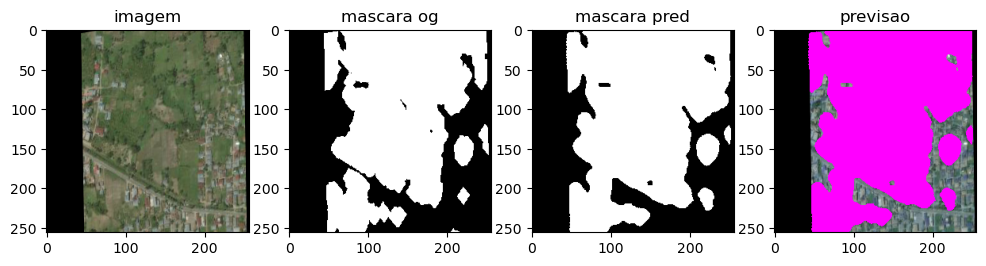

0.7509286009079653


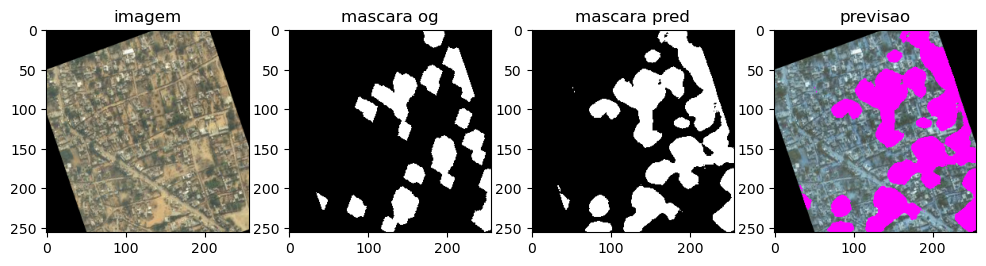

0.8708554811336495


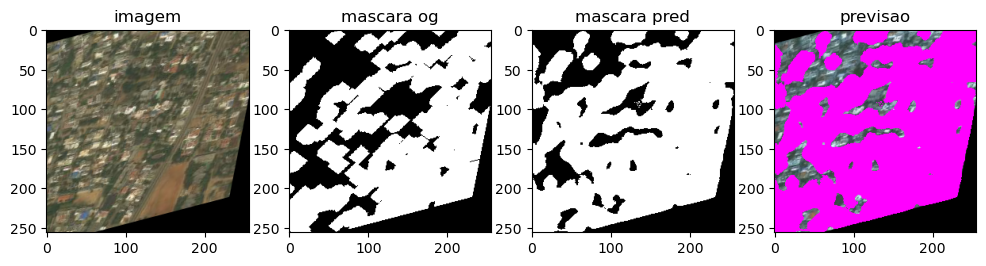

1


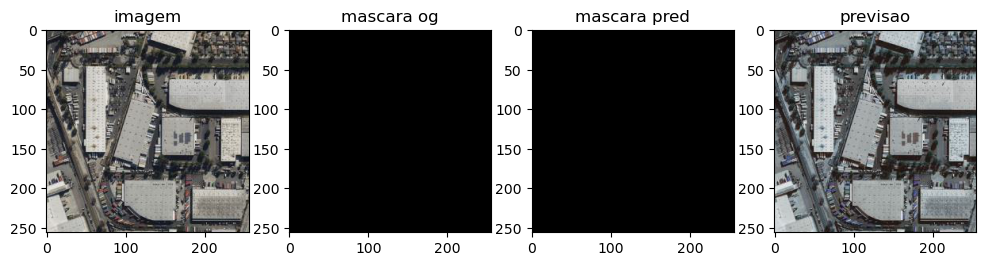

0.6725274725274726


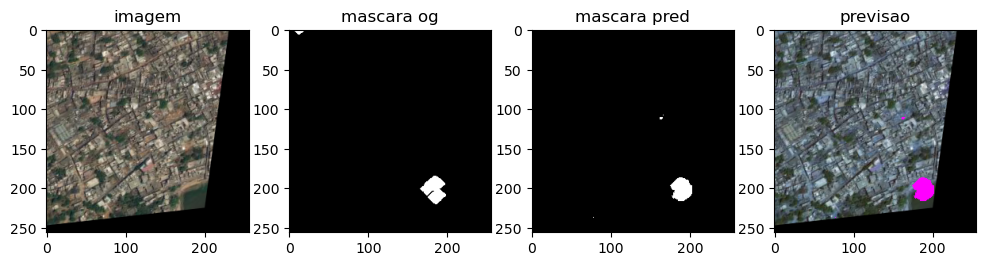

In [167]:
show_results(X_test, model)

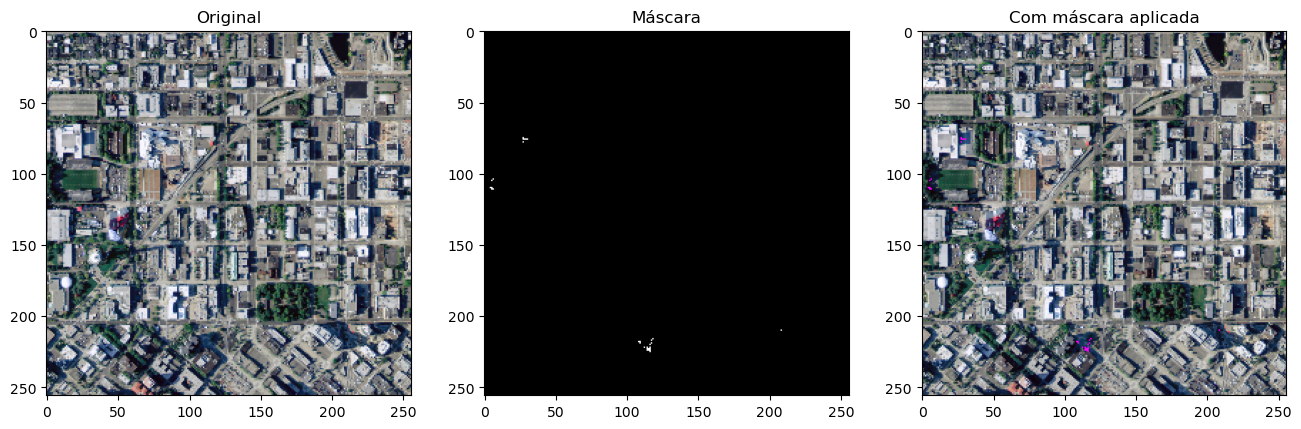

In [168]:
url = 'teste_giovanna.jpg'
import requests, io
import numpy as np
from PIL import Image

img = np.array(Image.open(url))[:, :, :3]
img = img/255.0
img = cv.resize(img, (256,256))
img = np.expand_dims(img, axis = 0)

plt.figure(figsize = (16, 12))

plt.subplot(1, 3, 1)
plt.title("Original")
plt.imshow(img[0])

plt.subplot(1, 3, 2)
plt.title("Máscara")
pred = make_pred_good(model(img))
pred[pred>0.5] = 1.0
pred[pred<0.5] = 0.0
plt.imshow(pred)
#print(pred)
plt.imsave('filename.png', np.array(pred), cmap="gray")
#cv.imwrite('pred.png', pred)

plt.subplot(1,3,3)
plt.title("Com máscara aplicada")
pred = placeMaskOnImg(img[0], pred)
type(pred)
plt.imshow(pred)
# plt.savefig('pred.jpg')